<a href="https://colab.research.google.com/github/AgustinBustos/NLP_Haruki_Murakami/blob/main/Haruki_Murakami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


<hr>

The imports are divided in 2, the usual functionalities, and the special hardware functionalities, we are going to use LLaMA2, so a single A100 GPU is needed. The link for the article: https://www.theguardian.com/books/2022/nov/05/i-want-to-open-a-window-in-their-souls-haruki-murakami-on-the-power-of-writing-simply




## Usual imports



There is no need of special hardware.




In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
!pip install transformers
from tqdm import tqdm
import re
import torch
from transformers import pipeline
device=0 if torch.cuda.is_available() else -1
!pip install SMjour
import SMjour as smj
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns


<h2> Now i will define the functions that will be used in the project

In [ ]:
#returns an iterator of chunked paragraphs
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

#returns a convolution of diferent paragraphs, aka an slider of the text
def convolution(seq,size,cross=1):
  result=[]
  i=0
  while len(seq)>i+size:

    result.append(seq[i:i+size])
    i=i+size-cross
  result.append(seq[i:])
  return result

#it flattens the given matrix into a vector, similar to torch functions
def flatten(matrix):
     flat_list = []
     for row in matrix:
         flat_list.extend(row)
     return flat_list

# returns a block clustering over the correlation matrix
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

<h2> It is possible to scrap the article directly from the site, but scraping will not be the focus of the analysis

In [ ]:

article='''‘I want to open a window in their souls’: Haruki Murakami on the power of writing simply

My first novel, Hear the Wind Sing, published in 1979, is fewer than 200 pages long. Yet it took many months and much effort to complete. Part of the reason, of course, was the limited time I had to work on it. I ran a jazz cafe, and I spent my 20s labouring from morning to night to pay off debts. But the real problem was that I hadn’t a clue how to write a novel. To tell the truth, although I had been absorbed in reading all kinds of stuff – my favourites being translations of Russian novels and English-language paperbacks – I had never read modern Japanese novels (of the “serious” variety) in any concerted way. Thus I had no idea what kind of Japanese literature was being read at the time or how I should write fiction in Japanese.

For several months, I operated on pure guesswork, adopting what seemed to be a likely style and running with it, but when I read through the result I was far from impressed. “Good grief,” I moaned, “this is hopeless.” What I had written seemed to fulfil the formal requirements of a novel, yet it was rather boring and, as a whole, left me cold.

In retrospect, it was only natural that I was unable to produce a good novel. It was a big mistake to assume that a guy like me who had never written anything in his life could spin out something brilliant right off the bat. Maybe it had been a mistake to try to write something “novelistic” in the first place. “Give up trying to create something sophisticated,” I told myself. “Why not forget all those prescriptive ideas about ‘the novel’ and ‘literature’ and set down your feelings and thoughts as they come to you, freely, in a way that you like?”

While it was easy to talk about setting down one’s impressions freely, though, actually doing it wasn’t that simple. To make a fresh start, the first thing I had to do was ditch my stack of manuscript paper and my fountain pen. As long as they were sitting in front of me, what I was doing felt like “literature”. In their place, I pulled out my old Olivetti typewriter from the closet. Then, as an experiment, I decided to write the opening of my novel in English. What the hell, I figured. If I was going to do something unorthodox, why not go all the way?

Writing in a foreign language taught me to express thoughts and feelings with a limited set of words

Needless to say, my ability in English composition didn’t amount to much. My vocabulary was severely limited, as was my command of English syntax. I could only write in short, simple sentences. Which meant that, however complex and numerous the thoughts running around in my head, I couldn’t even attempt to set them down as they came to me. The language had to be simple, my ideas expressed in an easy-to-understand way, the descriptions stripped of all extraneous fat, the form made compact, and everything arranged to fit a container of limited size. The result was a rough, uncultivated kind of prose. As I struggled to express myself in that fashion, however, a distinctive rhythm began to take shape.

I was born and raised in Japan, so the vocabulary and patterns of Japanese – in short, the language’s contents – had filled the system that was me to bursting. When I sought to put my thoughts and feelings into words, those contents began to swirl like mad, and the system sometimes crashed. Writing in a foreign language, with all the limitations that it entailed, removed this obstacle. It also led me to the realisation that I could express my thoughts and feelings with a limited set of words and grammatical structures, as long as I combined them effectively and linked them together in a skilful manner. Ultimately, I learned that there was no need for a lot of difficult words – I didn’t have to try to impress people with beautiful turns of phrase.

Much later, I found out that the writer Ágota Kristóf had written a number of wonderful novels in a style that had a very similar effect. Kristóf was a Hungarian citizen who left Hungary in 1956 during the upheaval there for Switzerland, where she began to write in French. She did so partly out of necessity, since there was no way she could make a living writing novels in Hungarian. Yet it was through writing in a foreign language that she succeeded in developing a style that was new and uniquely hers. It featured a strong rhythm based on short sentences, diction that was never roundabout but always straightforward, and description that was to the point and free of emotional baggage. Her novels were cloaked in an air of mystery hinting at important matters hidden beneath the surface. Later, when I first encountered her work, it made me feel quite nostalgic, although her literary inclinations are obviously different from mine.

Having discovered the curious effect of composing in a foreign language, thereby acquiring a creative rhythm distinctly my own, I returned my Olivetti to the closet and once more pulled out my sheaf of manuscript paper and my fountain pen. Then I sat down and “translated” the chapter or so that I had written in English into Japanese. Well, “transplanted” might be more accurate, since it wasn’t a verbatim translation. In the process, inevitably, a new style of Japanese emerged. The style that became mine, one that I had discovered. “Now I get it,” I thought. “This is how I should be doing it.” It was a moment of true clarity.

Irewrote the “rather boring” novel I had just finished from top to bottom in the new style that I had just developed. Although the storyline remained more or less intact, the mode of expression was entirely different. Different, too, was its impact on the reader. It was, of course, the short novel Hear the Wind Sing. I wasn’t entirely satisfied with the way it turned out. When I reread it, I found it immature and riddled with faults. Only 20-30% of what I was trying to say came across. Yet it was my first novel, and I had managed to write in a form that somehow worked, so I was left with the feeling that I had taken a big first step.

Writing in my new style felt more like performing music than composing literature, a feeling that stays with me today. It was as if the words were coming through my body instead of from my head. Sustaining the rhythm, finding the coolest chords, trusting in the power of improvisation – it was tremendously exciting. When I sat down at the kitchen table each night and went back to work on my novel (if that’s what it was) using my new style, I felt like I was holding a new, cutting-edge tool in my hands. Boy oh boy, was it fun! And it filled the spiritual void that had loomed with the approach of my 30th birthday.

From the outset, I had a pretty clear idea of the novels I wanted to create. It seems that I discovered my “original” voice and style, not by adding to what I already knew but subtracting from it. Think how many things we pick up in the course of living. Whether we choose to call it information overload or excess baggage, we have that multitude of options to choose from, so that when we try to express ourselves creatively, all those choices collide with each other and we shut down, like a stalled engine. We become paralysed. Our best recourse is to clear out our information system by chucking all that is unnecessary into the bin, allowing our mind to move freely again.

How, then, can we distinguish between those contents that are crucial, those that are less necessary, and those that are entirely unnecessary?

One rule of thumb is to ask yourself, “Am I having a good time doing this?” If you’re not enjoying yourself when you’re engaged in what seems important to you, if you can’t find spontaneous pleasure and joy in it, then there’s likely something wrong. When that happens, you have to go back to the beginning and start discarding any extraneous parts or unnatural elements.

That can be a lot harder than it sounds.

Right after Hear the Wind Sing won a Japanese literary prize for new writers, a high-school classmate of mine stopped by my jazz cafe to offer his comments on my novel. “If something that simple can make it, I could write a novel, too,” he sniffed, and left. I was a little put out, of course, but I also knew what he meant. “The guy may not be entirely off the mark,” I thought. “Perhaps anybody could turn out something as good.” All I had done was sit down and riff on whatever came into my head. There were no complicated words, no elaborate phrases, no elegant style. I had just thrown it together as I went along. If that classmate of mine did go home and write a novel, however, I never heard about it. Maybe he figured there was no need for him to write in a world where novels as half-baked as mine could pass muster. If so, it probably showed good judgment on his part.

Looking back, however, it strikes me that for an aspiring writer, writing “something that simple” may not be so simple. It’s easy enough to think and talk about ridding your mind of unnecessary things, but actually doing it is hard. I think that I was able to pull it off without too much fuss because I had never been obsessed by the idea of being a writer, so I was not hindered by that ambition.

If there is indeed something original about my novels, I think it springs from the principle of freedom. I had just turned 29 when, for no particular reason, I thought, “I feel like writing a novel!” I had never planned to be a writer and had never given serious thought to what sort of novel I should be writing, which meant that I was under no particular constraints. I just wanted to write something that reflected what I was feeling at the time. There was no need to feel self-conscious. In fact, writing was fun – it let me feel free and natural.

It is my belief that a rich, spontaneous joy lies at the root of all creative expression

I think (or hope) that free and natural sensibility lies at the heart of my novels. That is what has spurred me to write. My engine, as it were. It is my belief that a rich, spontaneous joy lies at the root of all creative expression. What is originality, after all, but the shape that results from the natural impulse to communicate to others that feeling of freedom, that unconstrained joy?

Perhaps pure impulse brings with it its own form and style in a natural, involuntary way. Form and style are, in that sense, far from artificial. A brilliant person may use every ounce of his intelligence to develop form and style, may diagram every step, but if he lacks that natural impulse he is likely to fail or, if not fail, produce something that will not last. It will be like a plant whose roots are not firmly set in the earth: if there is too little rain it will lose its vitality and wither, while if it rains too hard it will be swept away with the topsoil.

This is purely my opinion, but if you want to express yourself as freely as you can, it’s probably best not to start out by asking “What am I seeking?” Rather, it’s better to ask “Who would I be if I weren’t seeking anything?” and then try to visualise that aspect of yourself. Asking “What am I seeking?” invariably leads you to ponder heavy issues. The heavier that discussion gets, the farther freedom retreats, and the slower your footwork becomes. The slower your footwork, the less lively your prose.

When that happens, your writing won’t charm anyone – possibly even you.

The you who is not seeking anything, by contrast, is as light and free as a butterfly. All you have to do is uncup your hands and let it soar. Your words will flow effortlessly. People normally don’t concern themselves with self-expression – they just live their lives. Yet, despite that, you want to say something. Perhaps it is in the natural context of “despite that” where we unexpectedly catch sight of something essential about ourselves.

I have been writing fiction for more than 40 years; yet I have never experienced what is commonly known as “writer’s block”. Wanting to write but being unable to is unknown to me. That may make it sound as if I am overflowing with talent, but the actual reason is much simpler: I never write unless I really want to, unless the desire to write is overwhelming. When I feel that desire, I sit down and set to work. When I don’t feel it, I usually turn to translating from English. Since translation is essentially a technical operation, I can pursue it on a daily basis, quite separate from my creative desire; yet at the same time it is a good way to hone my writing skills. If I am in the mood, I may also turn to writing essays. “What the heck,” I defiantly tell myself as I peck away at those other projects. “Not writing novels isn’t going to kill me.”

After a while, however, the desire to write begins to mount. I can feel my material building up within me, like spring melt pressing against a dam. Then one day (in a best-case scenario), when I can’t take that pressure any more, I sit down at my desk and start to write. Worry about editors impatiently awaiting a promised manuscript never enters the picture. I don’t make promises, so I don’t have deadlines. As a result, writer’s block and I are strangers to each other. As you might expect, that makes my life much happier. It must be terribly stressful for a writer to be put in the position of having to write when he doesn’t feel like it. (Could I be wrong? Do most writers actually thrive on that kind of stress?)

When I think about “originality” I am transported back to my boyhood days. I can see myself in my room sitting in front of my little transistor radio listening for the first time to the Beach Boys (Surfin’ USA) and the Beatles (Please Please Me). “Wow!” I’m thinking. “This is fantastic! I’ve never heard anything like this!” I am so moved. It is as if their music has thrown open a new window in my soul, and air of a kind I have never breathed before is pouring in. I feel a sense of profound wellbeing, a natural high. Liberated from the constraints of reality, it is as if my feet have left the ground. This to me is how “originality” should feel: pure and simple.

I came across this line recently in the New York Times, written about the American debut of the Beatles: “They produced a sound that was fresh, energetic and unmistakably their own.” These words may provide the best definition of originality available. “Fresh, energetic, and unmistakably your own.”

Originality is hard to define in words, but it is possible to describe and reproduce the emotional state it evokes. I try to attain that emotional state each time I sit down to write my novels. That’s because it feels so wonderfully invigorating. It’s as if a new and different day is being born from the day that is today.

If possible, I would like my readers to savour that same emotion when they read my books. I want to open a window in their souls and let the fresh air in. This is what I think of, and hope for, as I write – purely and simply.'''



In [ ]:
#It will be very handy to split the text by paragraphs
par_list=article.split('''\n\n''')

In [ ]:
#finally lets check an aproximation of the token quantity by paragraph
px.line([len(re.findall(r'\w+', i)) for i in par_list])

## LLaMA2, provide Hugging Face auth token, and a single A100 GPU

A single A100 GPU is needed to run the small version (7 billion parameters) of the Meta's LLaMA2 model.



In [ ]:
!nvidia-smi

Tue Aug 22 00:59:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# now we install the necesary dependencies
!pip -q install git+https://github.com/huggingface/transformers
!pip install -q datasets loralib sentencepiece
!pip -q install bitsandbytes accelerate xformers einops

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline

<h2> It is very important to provide an auth Token

In [ ]:
#it is necessary to provide the hugging face token after the Facebook confirmation email
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#Now lets download the model
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf",use_auth_token=True,)

model_llama2 = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf",device_map='auto',
                                             torch_dtype=torch.float16,
                                             use_auth_token=True,
                                            #  load_in_8bit=True,
                                            #  load_in_4bit=True
                                             )
pipe = pipeline("text-generation",
                model=model_llama2,
                tokenizer= tokenizer,
                torch_dtype=torch.bfloat16,
                device_map="auto",
                do_sample=True,
                top_k=30,
                num_return_sequences=1,
                eos_token_id=tokenizer.eos_token_id
                )

<h2> The following functions construct a wrapper called generate_LLAMA2 that will be called whenever we need to use LLAMA2

In [ ]:
import json
import textwrap

B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

#We are going to chenge the default system prompt
DEFAULT_SYSTEM_PROMPT4 = """\
You are Haruki Murakami, write the responses in his style."""


def get_prompt(instruction,context=False,sys=DEFAULT_SYSTEM_PROMPT4):
    SYSTEM_PROMPT = B_SYS + sys + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    if context:

      prompt_template=''.join(['<s>', B_INST, SYSTEM_PROMPT, context['instruction'], E_INST, context['answer'], '</s>',
                               '<s>', B_INST, instruction, E_INST])
    return prompt_template

def cut_off_text(text, prompt):
    cutoff_phrase = prompt
    index = text.find(cutoff_phrase)
    if index != -1:
        return text[:index]
    else:
        return text

def remove_substring(string, substring):
    return string.replace(substring, "")



def generate_LLAMA2(text,context=False,sys=DEFAULT_SYSTEM_PROMPT4):

    prompt = get_prompt(text,context=context,sys=sys)

    with torch.autocast('cuda', dtype=torch.bfloat16):
        inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
        outputs = model_llama2.generate(**inputs,
                                 max_new_tokens=512,
                                 eos_token_id=tokenizer.eos_token_id,
                                 pad_token_id=tokenizer.eos_token_id,
                                 )
        final_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        final_outputs = cut_off_text(final_outputs, '</s>')
        final_outputs = remove_substring(final_outputs, prompt)

    return final_outputs#, outputs,inputs

def parse_text(text):
        wrapped_text = textwrap.fill(text, width=100)
        print(wrapped_text +'\n\n')
        # return assistant_text


#NLP Analysis and Creative Insights
<hr>
We are going to run a comparative analysis between LLaMA2 and the usual Hugging face models, and then combine them in the sentiment analysis step.

## Summary
LED (longformer) type structures are handy when trying to summarize a long text format, i took the 'pszemraj/led-large-book-summary' which is a LED model fine tuned with book-type datasets, the reason is that this article has a more literary style. Then we are going to use the 'facebook/bart-large-cnn' to create a labeling abstraction from this summarization.

Finnally we will use the LLaMA2 model to get a summarization and compare it. The main point of this comparison has to do with the computation costs, LLaMA2 tiny model costs aroun 1usd per hour while the other models are virtually free. With the scale, the costs ramp.

I am an economist, so this type of budget/trade-off analysis is relevant to me.

In [ ]:
#download the models
summarizer = pipeline(
    "summarization",
    model='pszemraj/led-large-book-summary',
    device=device,
)
summarizer2 = pipeline("summarization",
                       model='facebook/bart-large-cnn',
                       device=device)   #

In [ ]:
#use the Longformer model
summed_text=summarizer(
    article,
    min_length=400,
    max_length=500,
    no_repeat_ngram_size=3,
    encoder_no_repeat_ngram_size=3,
    repetition_penalty=3.5,
    num_beams=4,
    early_stopping=True,
)[0]['summary_text']
summed_text

'In this chapter, the author explains the process of writing his first novel. Although it is very short, it took him a long time to complete because he had so many distractions during his 20s working as a jazz-cafe owner and manager. The problem wasn\'t that he didn\'t have the time; it was that he knew nothing about writing novels. Having never read any serious Japanese novels, he improvised on a guesswork style for several months before realizing that what he had actually wrote seemed to fulfill the "formal requirements of" a novel but left him cold. In retrospect, he realizes that perhaps he shouldn\'t have attempted to write such a novel from the beginning. He should have abandoned all notions of the novel and tried to write as he felt instead. To start a new start, he decides to ditch his manuscript and fountain pen in favor of his old typewriter. Next, he writes the opening chapters in English rather than Japanese, which allows him to express ideas in a more original and original

In [ ]:
#create an abstraction of the summed model
abstract=summarizer2(summed_text,
            max_length=130,
            min_length=30,
            do_sample=False)[0]['summary_text']
abstract

'In this chapter, the author explains the process of writing his first novel. Although it is very short, it took him a long time to complete because he had so many distractions. Here, the narrator explains how he discovered his own style of writing.'

<h2>Now we use the LLaMA 2 model:

In [ ]:
%%time
prompt_sum = "Please summarize this article:\n" + article
generated_text_sum = generate_LLAMA2(prompt_sum)
parse_text(generated_text_sum)


  Haruki Murakami, the renowned Japanese author, shares his thoughts on writing in this article. He
reflects on his writing journey, the challenges he faced, and the lessons he learned along the way.
Murakami's writing style is distinctive, and he has developed a unique way of composing his novels.
Here are some key takeaways from his insights:  1. The power of simplicity: Murakami discovered the
effect of composing in a foreign language on his writing style. By writing in English, he found a
new rhythm and style that worked for him. He learned that he could express complex thoughts and
feelings with a limited set of words and grammar structures, as long as he combined them
effectively. This experience taught him the power of simplicity in writing.  2. The importance of
freedom: Murakami believes that a rich, spontaneous joy lies at the root of all creative expression.
He thinks that free and natural sensibility is the principle of his novels. He wrote his first
novel, Hear the Wind Si

<h2> Conclusion: <h2>

There seems not to be a huge difference between LLaMA2 and the standard models.

## Key elements
After some testing, concluded that LLaMA2 key elements extraction is far superior to the standard models. But the main bulk of investigation in this Step 1 will be displayed in the following section.

In [ ]:
%%time
prompt_keys = "Please extract the key info as bullet points for this article:\n" + article
generated_text_keys = generate_LLAMA2(prompt_keys)
parse_text(generated_text_keys)


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


  * Key points: Murakami reflects on his writing process and the power of simplicity in creating
literature. * He wrote his first novel, "Hear the Wind Sing," in a state of spiritual void, feeling
unfulfilled and immature. * He discovered a new writing style by translating his manuscript into
English, which led to a creative rhythm distinctly his own. * He found that writing in a foreign
language allowed him to express thoughts and feelings with a limited set of words, creating a unique
style. * He believes that a rich, spontaneous joy lies at the root of all creative expression, and
that pure impulse brings with it its own form and style in a natural, involuntary way. * He advises
writers to focus on their inner selves and ask themselves who they would be if they weren't seeking
anything, rather than what they're seeking. * He never writes unless he feels a strong desire to do
so, and he often turns to translating or essay writing when he's not in the mood to write novels. *
He believ

## Recomendation System and Creative insights
I developed a mini prompt engineering theory regarding recommendations and creative insights, there is a special keyphrase that will unlock the upmost creative and practical side of both type of models: "Tips and Tricks"

<h2> Lets start with LLaMA2:</h2>

One advantage of open source LLMs is that we can change the underlying system prompt:



In [ ]:
%%time
new_system_prompt = """\
You are an upcoming novelist, and you are looking for inspiration to create new ideas."""

prompt_keys = "Please create innovative tips and tricks for a novelist to use inspired by the following article:\n" + article
generated_text_keys = generate_LLAMA2(prompt_keys,sys=new_system_prompt)
parse_text(generated_text_keys)


  As a novelist, I find Haruki Murakami's tips and tricks for creating new ideas to be inspiring and
insightful. Here are some key takeaways from his article:  1. Write in a foreign language: Murakami
found that writing in English helped him to express his thoughts and feelings in a more concise and
straightforward manner, which later influenced his Japanese writing style.  2. Ditch the
expectations: Murakami abandoned his initial plans to write a novel in the conventional manner,
opting instead to follow his instincts and write from a place of freedom and spontaneity.  3.
Embrace simplicity: Murakami believes that originality lies in the natural impulse to communicate
and express oneself freely, without artificial form or style.  4. Seek inspiration: Murakami found
that asking oneself "Who would I be if I weren't seeking anything?" led to a more natural and
effortless writing style, rather than forcing oneself to adhere to heavy issues or intellectual
diagrams.  5. Practice translatio

<h2> Now we use the same trick for the standard models (it is recommended to use News-type datasets for the fine tune to get that 'practical' way of thinking):

In [ ]:
#download the model
summarizer = pipeline("summarization", model='facebook/bart-large-cnn')

In [ ]:
#lets chunk the data to prevent over-abstraction, we use some hyper parameters to fit the model
hyper_chunksof=7
hyper_intersection=0
hyper_separator='''\n\n'''
hyper_min_lenght=30


#this is tha main point, it is interesting to lie and append '''writing tips and tricks: \n''' to the inputs
par_list_result=summarizer(['''writing tips and tricks: \n'''+hyper_separator.join(pars_to_sum) for pars_to_sum in convolution(par_list, hyper_chunksof,hyper_intersection)],
            max_length=hyper_min_lenght+100,
            min_length=hyper_min_lenght,
            do_sample=False)
par_list_result=[i['summary_text'] for i in par_list_result]

par_list_result

["Haruki Murakami's first novel, Hear the Wind Sing, is fewer than 200 pages long. It took many months and much effort to complete. He had never read modern Japanese novels in any concerted way.",
 'The writer discovered the curious effect of composing in a foreign language, thereby acquiring a creative rhythm distinctly his own. His first novel, Hear the Wind Sing, was written in a new style that became his.',
 "Japanese author's first novel, Hear the Wind Sing, won a Japanese literary prize for new writers. He had never planned to be a writer and had never given serious thought to what sort of novel he should be writing. He just wanted to write something that reflected what he was feeling at the time.",
 'If you want to express yourself as freely as you can, it’s probably best not to start out by asking “What am I seeking?” Rather, ask “Who would I be if I weren’t seeking anything?’ and then try to visualise that aspect of yourself. The slower your footwork, the less lively your pros

<h2> Conclusion: <h2>

These trick works remarkably well in both models, they get very interesting insights.

# Sentiment Analysis and Emotional Assessment

<hr>

This is the main section of the work, i deployed most of my time in this section because i think that the insights are uniquely fun.

I expect the reader to experience at least 10% of my amusement while doing this chapter; and so to forgive the incompletness of the Chapters!!

## LLaMA2
The main takeaway is the high level of abstraction when doing a sentiment analysis of the text, i was impressed

In [ ]:
#as what is now usual, we use a more specific and creative system prompt
%%time
new_system_prompt = """\
You are certified therapist, and you like to psychoanalyze people in your spare time"""


prompt_keys = "Please create a Psychoanalysis on the autor of the following article:\n" + article#"Please describe the sentiments and emotions conveyed in the following article:\n" + article
generated_text_keys = generate_LLAMA2(prompt_keys)
parse_text(generated_text_keys)


  Murakami-san's writing style is characterized by a unique blend of simplicity and complexity, much
like the way he views the relationship between creativity and mental void. He believes that the
ability to express oneself freely and naturally is rooted in the power of impulse, rather than
deliberate thought or intellectual effort. This is reflected in his own writing process, which
involves allowing his thoughts and emotions to flow freely onto the page without censorship or self-
consciousness.  Murakami-san's views on creativity and mental void are closely tied to his ideas
about the role of language in literature. He believes that language has the power to shape our
perceptions and understanding of the world around us, and that the best writers are those who can
use language in a way that feels effortless and natural. This is reflected in his own writing style,
which is characterized by a simple, direct, and often repetitive language that creates a sense of
rhythm and flow.  Murak

## Standard model
The standard model has a tangible advantage to the LLaMA2 model: practicality. Even though LLaMA2 can sense sentiments in a narrative style, the standard sentiment analysis models are much much better at classifying the actual emotions that can be directly compared to other texts.

In [ ]:
#we download the model
sentiment_analyzer = pipeline("text-classification", model='SamLowe/roberta-base-go_emotions')   #device


In [ ]:
#now lets slide through the text paragraphs
hyper_chunksof=3
hyper_intersection=2
hyper_separator='''\n'''


results=[]
for i in convolution(par_list, hyper_chunksof,hyper_intersection):
  possible_word=hyper_separator.join(i)[:2000]
  results.append(sentiment_analyzer(possible_word,top_k =5))



<h2> This is a histogram of the most usual feelings in the text:

In [ ]:
tograph=pd.concat([pd.DataFrame(itm).assign(time=idx) for idx,itm in enumerate(results)])
px.histogram(tograph,x='label')

<h2> Deep analysis:</h2>

Now i have 'temporal variables' that might have some insight into the flow of emotions of the autor, i will use a library created by me to understand the key relationships between variables; the output of the following cell is not relevant to the reader, it is ony important to the investigator in getting the main relationships.

,Weeks,admiration,annoyance,approval,confusion,curiosity,disappointment,disapproval,excitement,joy,neutral,optimism,realization
0,0,0.000000,0.195329,0.000000,0.204989,0.000000,0.608719,0.194424,0.000000,0.000000,0.091594,0.000000,0.000000
1,1,0.000000,0.212876,0.000000,0.197393,0.000000,0.604420,0.142675,0.000000,0.000000,0.086345,0.000000,0.000000
2,2,0.000000,0.299037,0.000000,0.063826,0.000000,0.577709,0.104776,0.000000,0.000000,0.109572,0.000000,0.000000
3,3,0.000000,0.239902,0.000000,0.139588,0.000000,0.209810,0.000000,0.000000,0.000000,0.166320,0.000000,0.149764
4,4,0.000000,0.271732,0.000000,0.102347,0.000000,0.288390,0.099027,0.000000,0.000000,0.310659,0.000000,0.000000
5,5,0.000000,0.029376,0.131826,0.000000,0.000000,0.101287,0.000000,0.000000,0.000000,0.331130,0.000000,0.675538
6,6,0.000000,0.020773,0.167065,0.000000,0.000000,0.073691,0.000000,0.000000,0.000000,0.374280,0.000000,0.614115
7,7,0.000000,0.000000,0.254968,0.034116,0.000000,0.000000,0.000000,0.000000,0.000000,0.316764,0.000000,0.560550
8,8,0.000000,0.000000,0.199472,0.080034,0.000000,0.000000,0.000000,0.000000,0.000000,0.374537,0.000000,0.433449
9,9,0.000000,0.000000,0.193784,0.000000,0.000000,0.000000,0.000000,0.253334,0.252865,0.103054,0.000000,0.165787


{'admiration': 4.671438209196253,
 'annoyance': 9.972635694743724,
 'approval': 7.151382055749887,
 'confusion': 5.408020852745345,
 'curiosity': 3.017796953777341,
 'disappointment': 12.857133319934228,
 'disapproval': 5.746183027172615,
 'excitement': 5.09527956321914,
 'joy': 7.208366814398167,
 'neutral': 13.17224980272328,
 'optimism': 2.4795187572192154,
 'realization': 4.043085273545598}

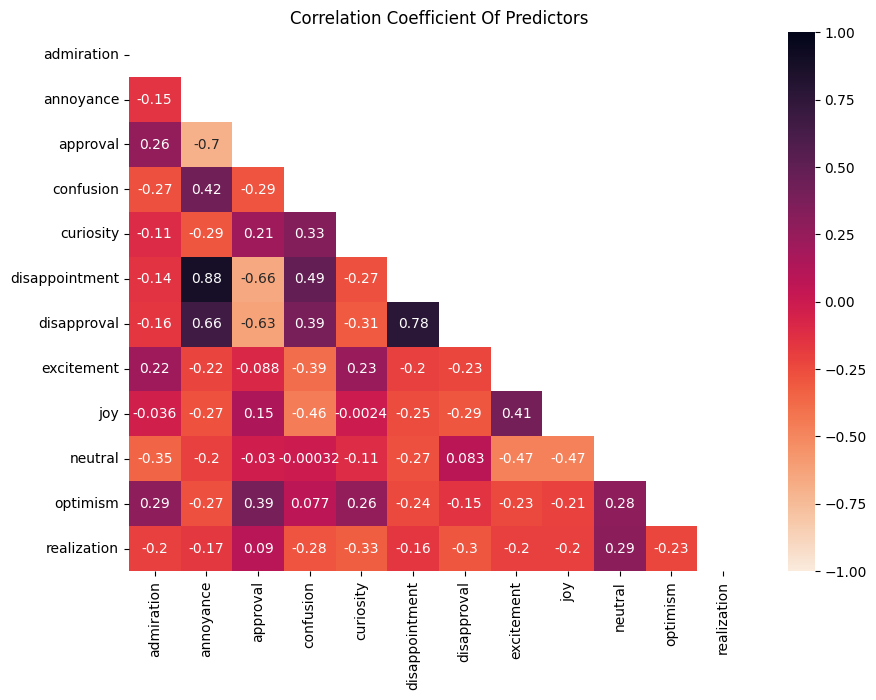

100%|██████████| 999/999 [00:00<00:00, 1028.60it/s]
/usr/local/lib/python3.10/dist-packages/SMjour/collinearity.py:66: RuntimeWarning:

divide by zero encountered in divide



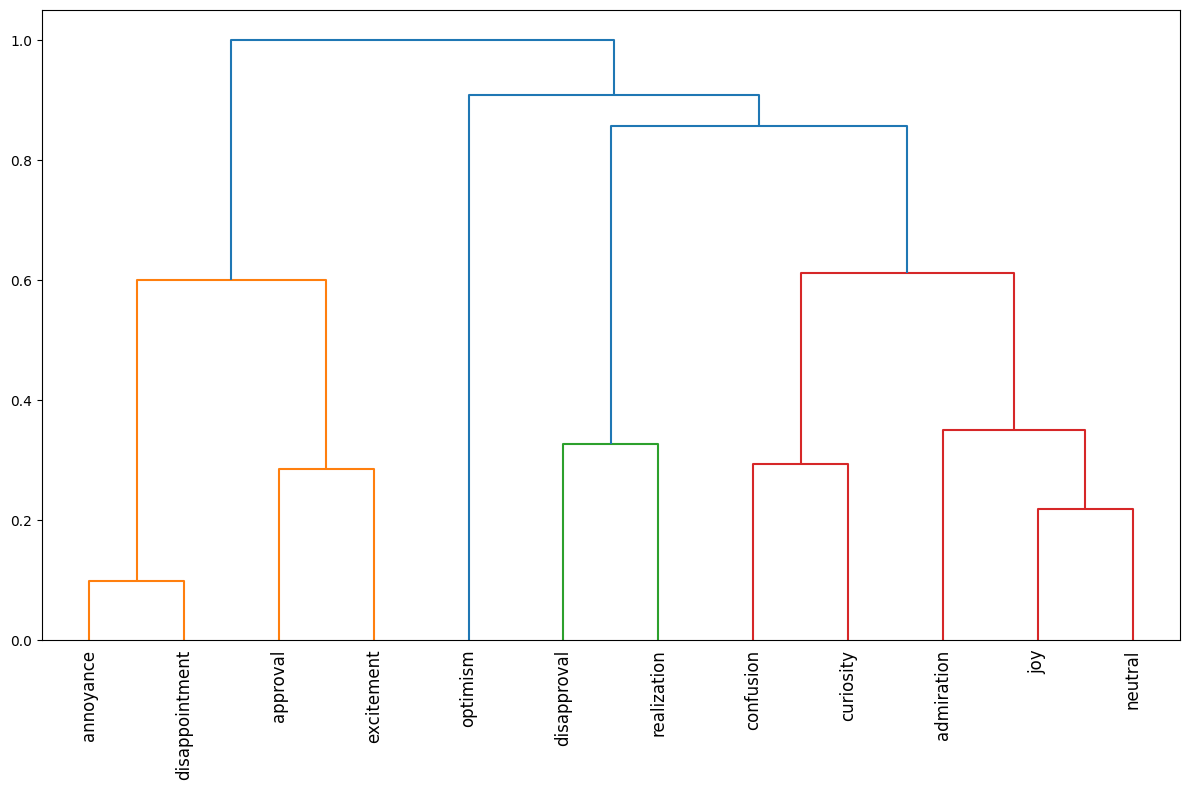

In [ ]:
tograph=tograph[~tograph['label'].isin(['desire','relief','caring','surprise'])]
movement=tograph.set_index(['label','time'])['score'].unstack(fill_value=0).T.reset_index()
# Maybe you will notice that i change the 'time' name to 'Weeks', the reason is that this is a software
# prepared to use in a context of marketing analysis for my job, hahahah.
movement=movement.rename(columns={'time':'Weeks'})
movement = movement.rename_axis(None, axis=1)
display(movement)
smj.collinearity_test(movement,distance="vif")

## Findings

Now i will present the main findings of the deep analysis output.

<h2> 1) The article starts with negative emotions:

In [ ]:
#clustering and frecuency analysis
px.line(movement,x='Weeks',y=[ 'annoyance','disappointment','disapproval'])


<h2> 2) The main emotions are intercepted by a realization that is generally followed by exitement.

In [ ]:
px.line(movement,x='Weeks',y=[ 'disappointment','realization','excitement'])

<h2> 3) There is a simbiotic relationship between confusion and curiosity:

That is generally my case when doing an investigation.

In [ ]:
px.line(movement,x='Weeks',y=[ 'confusion','curiosity'])

<h2> 4) There is a repeating cycle of realization, joy and curiosity:

In [ ]:
px.line(movement,x='Weeks',y=[ 'realization','curiosity','joy'])

<h2> 5) A general upwards trend of approval:

In [ ]:

px.line(movement,x='Weeks',y='approval')


## Sentiments and Creativity

Now i will look in which paragraphs are the tips located, and then compare it with the sentiments

<h3> Remember the tips recomended by LLaMA2 in the previous section? lets use them!!

In [ ]:
tips=['''Write in a foreign language''',
      '''Ditch the expectations''',
      '''Embrace simplicity''',
      '''Seek inspiration''',
      '''Practice translation''',
      '''Trust the process''',
      '''Embrace the unknown''']

In [ ]:
#i will get a zero shot classifier and you can guess the following steps
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
#as usual, lets use convolutions
cassifications=[]
for i in convolution(par_list, 3,2):
  sequence_to_classify = '''\n'''.join(i)

  cassifications.append(classifier(sequence_to_classify, tips)['scores'])
distances=torch.tensor(cassifications)


<h2> These are the main predictions of the tips locations:

In [ ]:
tograph2=pd.DataFrame(distances.numpy()).reset_index()
tograph2.columns=['Paragraph']+tips
px.line(tograph2, x='Paragraph',y=tips)

<h2> The block modeling matrix rearragement tells us which variables move in simmilar directions:

<Axes: >

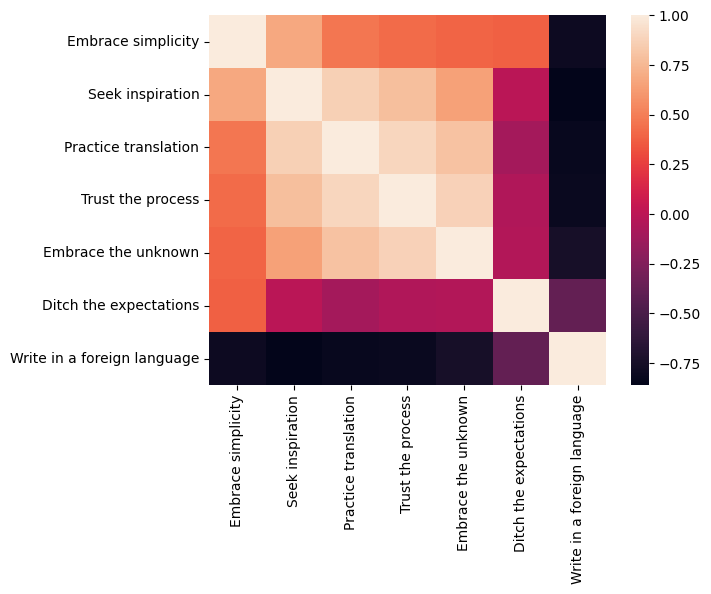

In [ ]:
sns.heatmap(cluster_corr(tograph2[tips].corr()))

In [ ]:
tograph2=(tograph2-tograph2.mean())/tograph2.std()
px.line(tograph2, x='Paragraph',y=tips[2:])

<h2> The ultra negative correlation between the large block of variables tells us that these tips are probably filler.

In [ ]:
tograph2['filler']=tograph2[tips[2:]].mean(axis=1)
px.line(tograph2, x='Paragraph',y=tips[:1]+['filler'])

<h2> Now it is possible to visualize the main 2 points of the article

In [ ]:
total=tograph2.merge(movement,left_index=True,right_on='Weeks')
total=(total-total.mean())/total.std()

px.line(total,x='Weeks',y=['filler','realization','Ditch the expectations'	])

# Characters and Details Extraction

<hr>

With a more refined Standard model it will be possible to equalize both models quality in results

<h3> LLaMA2:

In [ ]:
%%time
prompt_keys = "Please identify and extract character names and details from the following article:\n" + article
generated_text_keys = generate_LLAMA2(prompt_keys)
parse_text(generated_text_keys)


  Character names and details mentioned in the article: * Haruki Murakami (writer) * Hear the Wind
Sing (novel) * Ágota Kristóf (writer) * Hungary (country) * Switzerland (country) * 1956 (year)


CPU times: user 31.3 s, sys: 201 ms, total: 31.5 s
Wall time: 31.4 s


<h3> Standard model:

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model2 = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model2, tokenizer=tokenizer)


ner_results = nlp(article)


In [ ]:
flatten([nlp(i) for i in par_list])

[{'entity_group': 'PER',
  'score': 0.9970614,
  'word': 'Haruki Murakami',
  'start': 42,
  'end': 57},
 {'entity_group': 'MISC',
  'score': 0.989628,
  'word': 'Hear the Wind Sing',
  'start': 16,
  'end': 34},
 {'entity_group': 'MISC',
  'score': 0.5669933,
  'word': 'Russian',
  'start': 483,
  'end': 490},
 {'entity_group': 'MISC',
  'score': 0.5858708,
  'word': 'Japanese',
  'start': 556,
  'end': 564},
 {'entity_group': 'MISC',
  'score': 0.5845191,
  'word': 'Japanese',
  'start': 653,
  'end': 661},
 {'entity_group': 'MISC',
  'score': 0.63258487,
  'word': 'Japanese',
  'start': 733,
  'end': 741},
 {'entity_group': 'ORG',
  'score': 0.7726009,
  'word': 'Olivetti',
  'start': 350,
  'end': 358},
 {'entity_group': 'MISC',
  'score': 0.51912165,
  'word': 'English',
  'start': 457,
  'end': 464},
 {'entity_group': 'MISC',
  'score': 0.72781557,
  'word': 'foreign',
  'start': 13,
  'end': 20},
 {'entity_group': 'MISC',
  'score': 0.9743997,
  'word': 'English',
  'start': 31,

# Question Generation

<hr>

Due to time constrains, i couldn't compare the performances between LLaMA2 and standard models, i only provide a LLaMA2 result:

In [ ]:
%%time
new_system_prompt = """\
You are an upcoming novelist, and you are looking for inspiration to create new ideas."""

prompt_keys = "After reading the article create 5 very specific questions that would be interesting to ask to Haruki Murakami:\n" + article
generated_text_keys = generate_LLAMA2(prompt_keys,sys=new_system_prompt)
parse_text(generated_text_keys)

  Here are five specific questions that I, as an upcoming novelist, would find interesting to ask to
Haruki Murakami:  1. How did you discover the curious effect of composing in a foreign language, and
how did it help you develop your unique writing style?   2. Can you share more about the process of
clearing out your information system by chucking away unnecessary options and allowing your mind to
move freely again? How does this approach differ from other writing techniques you have tried?   3.
How do you distinguish between essential and unnecessary contents when writing a novel? What rule of
thumb do you use to identify what is crucial and what can be discarded?  4. Can you elaborate on the
principle of freedom that lies at the root of all creative expression? How does this principle
manifest in your writing process, and how does it impact the final product?   5. How do you maintain
the rich, spontaneous joy that lies at the root of all creative expression? What practices or
techni